In [ ]:
from nbdev import *
%nbdev_default_export cell_data
%reload_ext autoreload
%autoreload 2

Cells will be exported to wtlike.cell_data,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Manage cell data
> Create cells from source data

In [ ]:
%nbdev_export
import os
import numpy as np
import pandas as pd
from wtlike.config import *
from wtlike.source_data import *
from wtlike.loglike import LogLike, PoissonRep

In [ ]:
%nbdev_export
class CellData(SourceData):
    """Manage a set of cells generated from a data set
    
        Invoke superclass to load photon data and exposure for the source.
        Manage a list of cells
        
        * config Config instance, with file paths appropriate for SourceData
        * source PointSource instance
        * bins time bins defined by 3-element tuple: 
        """
    
    def __init__(self, *pars, **kwargs): #config, source,  bins=(0,0,1), clear=False)):
        """

        """
        bins = kwargs.pop('bins', (0,0,1))
        #  load phots
        super().__init__(*pars, **kwargs )

        self.use_uint8  = self.config.use_uint8
#
        self.rebin(bins)
        self.get_cells()
        
    def get_cells(self):
        if not hasattr(self, 'df') or self.df is None:
            self.df = pd.DataFrame([cell for cell in self if cell['e']>0  and cell['n']>0 ])
        return self.df
        
    def rebin(self, newbins):
        """bin, or rebin 
        """
        photon_data = self.p_df
        edges = time_bin_edges(self.config, self.e_df, newbins)
        if self.config.verbose>0:
            print(f'Bin photon data into {len(edges)-1} {bin_size_name(newbins[2])}'\
                  f' bins from {edges[0]} to {edges[-1]}')
        
        # exposure binned as well
        self.fexposure, self.expbin = self.binned_exposure( time_bins=edges ) 
        
        ### fix normalization
        self.fexposure /= (len(edges)-1)
        
        # manage bins 
        self.N = len(edges)-1 # number of bins
        self.bins = edges
        self.bin_centers = 0.5*(edges[1:]+edges[:-1])
        self.exposure_fator = 1
        
        # restrict photons to range of bin times
        photons = photon_data.query(f'{edges[0]}<time<{edges[-1]}')

        # get the photon data with good weights, not NaN
        w = photons.weight
        good = np.logical_not(np.isnan(w))
        self.photons = photons.loc[good]
        self.weights = w = self.photons.weight.values
        
        # estimates for signal and background per cell ???
        self.S = np.sum(w) #/self.N
        self.B = np.sum(1-w)#/self.N

        # use photon times to get indices of bin edges
        self._edges = np.searchsorted(self.photons.time, edges)

    def update(self): pass # virtual
    
    def rebinned_copy(self, newbins):
        """Return a rebinned copy
        
        """
        import copy
        if self.config.verbose>1:
            print(f'Making copy of rebinned class {self.__class__}')
        r = copy.copy(self)
        # check to see if new binning is contained
        r.rebin(newbins)
        r.df = None # force new set of cells
        if newbins[0]> self.bins[0] or newbins[-1] < self.bins[1]:
            factor = self.expbin/r.expbin            
            if self.config.verbose>0:
                print(f'The new range is within old--bin exposure factor {factor:.1f}')
            r.exposure_factor=factor # to apply later
        r.update()
        return r
        
    
    def __repr__(self):
        return f'''{self.__class__}:
        {len(self.fexposure)} intervals from {self.bins[0]:.1f} to {self.bins[-1]:.1f} for source {self.source_name}
        S {self.S:.2f}  B {self.B:.2f} '''

    def __getitem__(self, i):
        """ get info for ith time bin and return dict with
            t : MJD time of center
            tw: bin width,
            e : exposure as fraction of total,
            n : number of photons in bin
            w : list of weights in float32 or uint8 integers<=255
            S,B:  value
        """
        k   = self._edges
        w = self.weights[k[i]:k[i+1]]
        wts = np.array(w*256, np.uint8) if self.use_uint8 else w
        n = len(wts)
        e = self.fexposure[i]
        tw  = self.bins[i+1]-self.bins[i]

        return dict(
                t=self.bin_centers[i], # time
                tw = tw,  # bin width
                e=e, 
                n=n, # number of photons in bin
                w=wts,
                S= e * self.S,
                B= e * self.B,
                )

    def __len__(self):
        return self.N
    
    def concatenate( self ):
        """
        Combine this set of cells to one
        Return a dict with summed n, S, B, and concatenated w
        """
        self.get_cells()
        cells = self.df
        
        newcell = dict()

        if 't' in cells:
            ca, cb =cells.iloc[0], cells.iloc[-1]
            newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

        for col in ' n S B'.split():
            newcell[col] = cells[col].sum()
        newcell['w'] = np.concatenate(list(cells.w.values))
        return newcell
    
        
    def full_likelihood(self ):
        """Concatentate all the cells, return a LogLike object
        """
        return LogLike(self.concatenate()) 
    
    def plot_concatenated(self, fignum=1, **kwargs):
        """Likelihood function, with fit for concatenated data
        """
        import matplotlib.pyplot as plt
        lka = self.full_likelihood()
        fig,ax = plt.subplots(figsize=(4,2), num=fignum)
        lka.plot(ax=ax, **kwargs) 
        return fig

In [ ]:
show_doc(CellData)

<h2 id="CellData" class="doc_header"><code>class</code> <code>CellData</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>CellData</code>(**\*`pars`**, **\*\*`kwargs`**) :: [`SourceData`](/wtlikesource_data#SourceData)

Manage a set of cells generated from a data set

Invoke superclass to load photon data and exposure for the source.
Manage a list of cells

* config Config instance, with file paths appropriate for SourceData
* source PointSource instance
* bins time bins defined by 3-element tuple: 

photons and exposure for Geminga: Restoring from cache with key "Geminga__data"
CellData: Source Geminga with:
	 data:     1,412,008 photons from   2008-08-04 to 2021-04-28
	 exposure: 3,112,161 intervals from 2008-08-04 to 2021-04-28
Bin photon data into 4650 1-day bins from 54683.0 to 59333.0
Parmeters from Poisson fit
flux                      1
ts                  2.5e+06
errors    (0.0012, -0.0012)
limit                     1
dtype: object


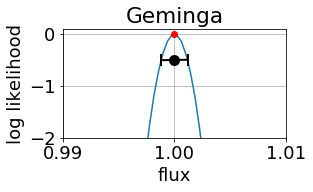

In [ ]:
%nbdev_hide

cd = CellData('Geminga')
cd.plot_concatenated(xlim=(0.99, 1.01), title=f'{cd.source.name}');
print('Parmeters from Poisson fit')
L = cd.full_likelihood()
pr = PoissonRep(L)
print(pd.Series(pr.info()))

In [ ]:

%nbdev_export
def concatenate_cells( cells):
    """
    Combine a group of cells to one
    - cells: dataframe with cells containing  n, w, S, B<br>
            Optionally, if $t$ is present, generate t and tw
    Return a dict with summed n, S, B, and concatenated w
    """
    newcell = dict()
    if 't' in cells:
        ca, cb =cells.iloc[0], cells.iloc[-1]
        newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

    for col in ' n S B'.split():
        newcell[col] = cells[col].sum()
    newcell['w'] = np.concatenate(list(cells.w.values))
    return newcell

In [ ]:
%nbdev_export
def partition_cells(config, cells, edges):
    """ Partition a set of cells
     - cells -- A DataFrame of cells
     - edges  -- a list of edge times delimiting boundaries between cells
     
    Returns a DataFrame of combined cells, with times and widths adjusted to account for missing cells
    
    """
    # get indices of  cell idexes just beyond each edge time
    ii = np.searchsorted(cells.t, edges)
    
    # Get the appropriate boundary times to apply to combined cells
    # this is complicated by missing cells, need to put boundary in gaps if ncessary
    ileft = ii[:-1]
    cleft = cells.iloc[ileft ]
    tleft =  (cleft.t - cleft.tw/2).values
    iright = ii[1:]-1
    cright = cells.iloc[iright ]  
    tright = (cright.t+cright.tw/2).values
    betweens = 0.5*(tleft[1:] + tright[:-1])
    tboundary = np.append(np.insert(betweens, 0, tleft[0]), tright[-1])
    
    # now combine the cells, 
    newcells = []
    for k in range(len(ii)-1):
        a,b = ii[k:k+2]
        subset = cells.iloc[a:b]; 

#         ca, cb = subset.iloc[0], subset.iloc[-1]
#         newcell = dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2)  )
        tl, tr = tboundary[k:k+2]
        newcell = dict(t=0.5*(tl+tr), tw=tr-tl)
        
        for col in 'e n S B'.split():
            newcell[col] = subset[col].sum()
        newcell['e'] /= len(subset)
        newcell['w'] = np.concatenate(list(subset.w.values)) #np.array(w, np.uint8)
        newcells.append(newcell)
    return pd.DataFrame(newcells)      

In [ ]:
show_doc(partition_cells)

<h4 id="partition_cells" class="doc_header"><code>partition_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>partition_cells</code>(**`config`**, **`cells`**, **`edges`**)

Partition a set of cells
 - cells -- A DataFrame of cells
 - edges  -- a list of edge times delimiting boundaries between cells
 
Returns a DataFrame of combined cells, with times and widths adjusted to account for missing cells

In [ ]:
%nbdev_hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_data_man.ipynb.
Converted 03_source_data.ipynb.
Converted 03_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cell_data.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Mon May  3 17:12:35 PDT 2021
